This is the documentation for "M1M2: Deep-Learning-Based Real-Time Emotion Recognition from Neural Activity" paper by

Sumya Akter 1†, Rumman Ahmed Prodhan 1†, Tanmoy Sarkar Pias 2* , David Eisenberg 3*
and Jorge Fresneda Fernandez 1

1.   Martin Tuchman School of Management, New Jersey Institute of Technology, Newark, NJ 07102, USA 
2.   Department of Computer Science, Virginia Tech, Blacksburg, VA 24061, USA
3. Department of Information Systems, Ying Wu College of Computing, New Jersey Institute of Technology, Newark, NJ 07102, USA

\* Correspondence: tanmoysarkar@vt.edu (T.S.P.); de63@njit.edu (D.E.)

† These authors contributed equally to this work.

Published in MDPI Sensors: https://www.mdpi.com/1424-8220/22/21/8467

https://doi.org/10.3390/s22218467








Table 7. Selecting the most optimal 1D CNN model.


**Pyeeg has been installed**

In [ ]:
pip install git+https://github.com/forrestbao/pyeeg.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-2s5dh39u
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-2s5dh39u
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done


**Here is the code for mounting google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyeeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Imported the necessery library packages**

In [ ]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

**Location of dat file and location for where to save preprocessed npy files**

In [ ]:
path_to_dataset_2 = '/content/drive/Shareddrives/DEAP EEG/Dataset/physiological_recordings/data_preprocessed_python/' #Location of dat file of DEAP dataset
path_to_dataset = '/content/drive/Shareddrives/DEAP EEG/Preprocessed_data/' #where to save preprocessed npy files

**Intialize the channel array, band array, window_size, step_size and sample_rate and set the path of dataset of google drive.**

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+

band = [4,8,12,16,25,45] #5 bands

window_size = 1664 #Averaging band power of 2 sec// 
#window_size = [128, 256, ..., 8064]

step_size = 16 #Each 0.125 sec update once

sample_rate = 128 #Sampling rate of 128 Hz

subjectList=[] #taking an empty array to store subject numbers here
for i in range(1,33):
  if i<10:
     subjectList.append(f"{i:02d}") #to add extra '0' infront of 1 to 9 single digits
  else:
    subjectList.append(f"{i:2d}")


**Declaring FFT function. Taking the preprocessed dat file and converting it to a preprocessed npy file after FFT**

In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open(path_to_dataset_2+'s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save(path_to_dataset+'s' + sub, meta, allow_pickle=True, fix_imports=True) #saving each of the 32 files as npy after preprocessing

**Calling the FFT functions for each subjects**

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [ ]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

##Dividing the Data into Training and Testing


#spliting and appending each npy into training, testing (75/25)
Dividing the 32 preprocessed npy file into data training, label training, data testing and label testing. Every npy file has 19520 rows and 4 columns which are valence, arousal, dominace and likings. Every npy file was divided by 4.

For each npy file

*   Training : 19520-4880=14640 (75%)
*   Testing : 19520/4=4880 (25%)

For training and testing
* The data training and label training both has 14640*32=468480 rows (75%)
* The data testing and label testing both has 4880*32=156160 rows (25%)









In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(path_to_dataset + 's' + subjects + '.npy', 'rb') as file: 
        sub = np.load(file) # loading npy file
        for i in range (0,sub.shape[0]): # running loop over 19520 rows
            if i % 4 == 0: # 19520/4=4880 (25%)
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            else: # 19520-4880=14640 (75%)
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

In [ ]:
# restore np.load for future normal usage
np.load = np_load_old

**Saving the data training, label training, data testing and label testing into google drive**


In [ ]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (384000, 70) (384000, 4)
testing dataset: (128000, 70) (128000, 4)


**Here all the training file have been loaded .The data have been put in variable X and label values have been put in Y.Then the X has been Normalized and then valence label values have been loaded in Z. And then all the '9' values are converted into '8.99' of valence label.**

In [ ]:
with open(path_to_dataset + 'data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [0]])

Valence_Train = np.ravel(Y[:, [0]])
Arousal_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

for i in range(len(Z)):
  if Z[i] == 9:
    Z[i] = 8.99

In [ ]:
Arousal_Train = Arousal_Train.reshape((468480, 1))
Domain_Train = Domain_Train.reshape((468480, 1))
Like_Train = Like_Train.reshape((468480, 1))

train = np.hstack([X, Arousal_Train, Domain_Train, Like_Train])
train.shape

(468480, 73)

In [ ]:
X_old = X
X = train

**All the training label values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for valence, arousal, dominance, likings binary classifications but not for other class classification.**


In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(Z)):
  if Z[i] >= 1 and Z[i]<=4.99:
    Z [i] = 0
    count_0 = count_0 + 1
  else:
    Z [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

203496 264984


**Necessery libraries are imported**


In [ ]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Conv1D
from tensorflow.keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
import warnings
warnings.filterwarnings('ignore')

**Here all the training label values are categorised. For binary classification and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'.** 

1.  1-4.99 ----> catagory(0)
2.  5-8.99 ----> catagory(1)

In [ ]:
y_train = to_categorical(Z)
y_train[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

**Values of X are put in x_train as numpy array format**

In [ ]:
x_train = np.array(X[:])

**Here all the testing file have been loaded .The data have been put in variable M and label values have been put in N.Then the M has been Normalized and then valence label values have been loaded in L. And then all the '9' values are converted into '8.99' of valence label.**

In [ ]:
with open(path_to_dataset + 'data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [0]])


Valence_Test = np.ravel(N[:, [0]])
Arousal_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

for i in range(len(L)):
  if L[i] == 9:
    L[i] = 8.99

**All the testing labels values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for valence, arousal, dominance, likings binary classifications but not for other class classification.**

In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(L)):
  if L[i] >= 1 and L[i]<=4.99:
    L [i] = 0
    count_0 = count_0 + 1
  else:
    L [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

67832 88328


In [ ]:
M.shape

(156160, 70)

In [ ]:
Arousal_Test = Arousal_Test.reshape((156160, 1))
Domain_Test = Domain_Test.reshape((156160, 1))
Like_Test = Like_Test.reshape((156160, 1))

test = np.hstack([M, Arousal_Test, Domain_Test, Like_Test])
test.shape

(156160, 73)

**Vules of M are assigned in x_test in numpy array format**

In [ ]:
x_test = np.array(test[:])
x_test

array([[0.07006464, 0.10438554, 0.06634758, ..., 7.6       , 6.9       ,
        7.83      ],
       [0.07695878, 0.10655808, 0.05897592, ..., 7.6       , 6.9       ,
        7.83      ],
       [0.07546743, 0.08606705, 0.07999725, ..., 7.6       , 6.9       ,
        7.83      ],
       ...,
       [0.1897225 , 0.11085076, 0.04970787, ..., 4.03      , 9.        ,
        1.88      ],
       [0.17817637, 0.08834064, 0.05389381, ..., 4.03      , 9.        ,
        1.88      ],
       [0.14543648, 0.08345535, 0.04799341, ..., 4.03      , 9.        ,
        1.88      ]])

**Here all the tessting labels values are categorised. For binary classification and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'.**

* 1-4.99 ----> catagory(0)
* 5-8.99 ----> catagory(1)

In [ ]:
from tensorflow.keras.utils import to_categorical 
y_test = to_categorical(L)

**Fit the train and test data with StandarScaler**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
#x_test = scaler.transform(x_test)

In [ ]:
x_test = scaler.transform(x_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

**Two dimensional data are converted into three dimension by adding one constant dimension’s value '1'. This is for CNN, LSTM and Bi-LSTM only**

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(468480, 73, 1) (156160, 73, 1) (468480, 2) (156160, 2)


In [ ]:
print(x_train.shape,  y_train.shape)

(468480, 73, 1) (468480, 2)


**Here define the batch_size, number of class used in model architecture ,how many epoch will be run with the model and also define the input_shape. This is for CNN, LSTM and Bi-LSTM only**

In [ ]:
batch_size = 256
num_classes = 2
epochs = 100

input_shape=(x_train.shape[1], 1)

**import another library packages**

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model

# Deep Learning Algorithms

##CNN Model with Residual Connection

**Table 7: 4 Conv + 3 Dense (M1)**

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 73, 32)       224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 73, 32)      128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 36, 32)       0           ['batch_normalization[0][0]']

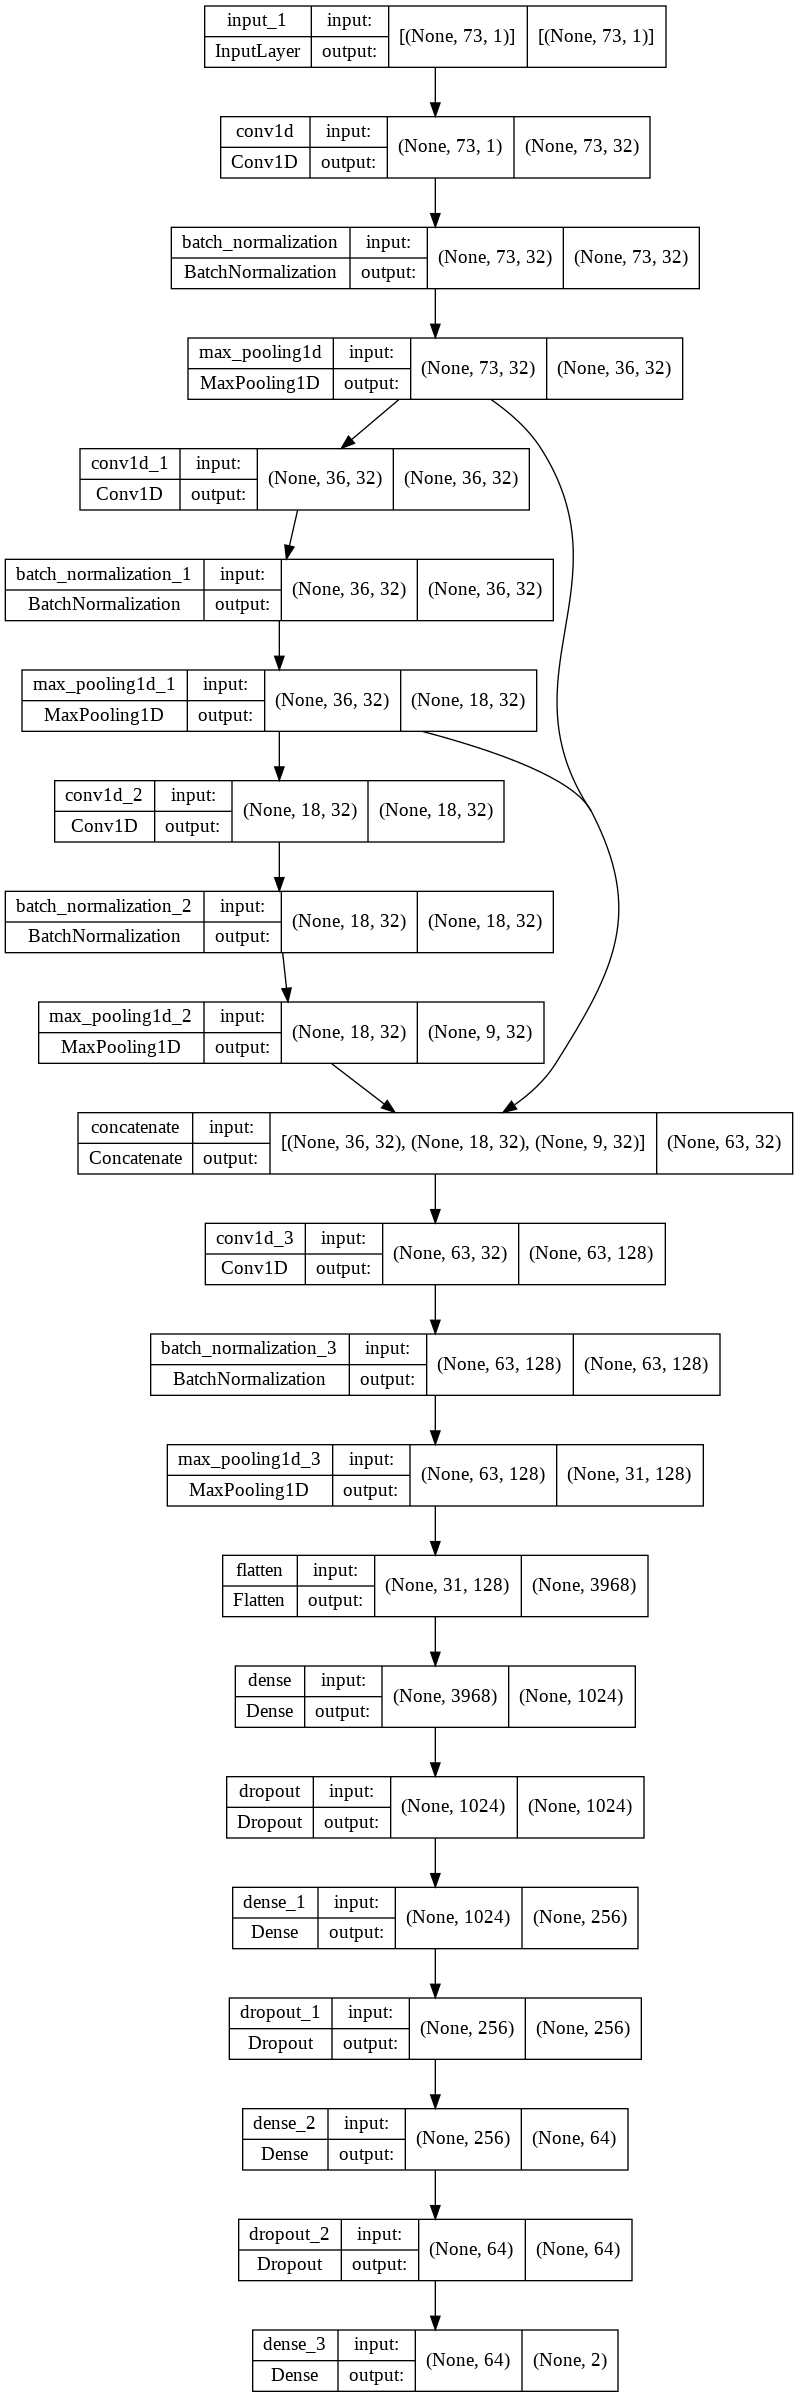

In [ ]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model


intput_shape=(x_train.shape[1], 1) #x_train.shape[1]

input_layer = Input(intput_shape)


conv1 = Conv1D(32, kernel_size=6,padding = 'same',activation='relu') (input_layer)
bn1 = BatchNormalization() (conv1)
pool1 = MaxPooling1D(pool_size=(2)) (bn1)

conv2 = Conv1D(32,kernel_size=6,padding = 'same', activation='relu') (pool1)
bn2 = BatchNormalization() (conv2) 
pool2 = MaxPooling1D(pool_size=(2)) (bn2)

conv3 = Conv1D(32,kernel_size=6,padding = 'same', activation='relu') (pool2)
bn3 = BatchNormalization() (conv3)
pool3 = MaxPooling1D(pool_size=(2)) (bn3)

connect1 = concatenate([pool1, pool2, pool3], axis=1)

conv4 = Conv1D(128,kernel_size=6,padding = 'same', activation='relu') (connect1)
bn4 = BatchNormalization() (conv4)
pool4 = MaxPooling1D(pool_size=(2)) (bn4)

flat = Flatten() (pool4)

dense1 = Dense(1024, activation='relu') (flat)
drop1 = Dropout(0.2) (dense1)

dense2 = Dense(256, activation='relu') (drop1)
drop2 = Dropout(0.2) (dense2)

dense3 = Dense(64, activation='relu') (drop2)
drop3 = Dropout(0.2) (dense3)

output_layer = Dense(2, activation='softmax') (drop3) #num_classes

model = Model(input_layer, output_layer)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Compiling the model**

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer='adam',
              metrics=['accuracy'])

**Automatic save 
(We have saved all the details of every epoch in google drive so that we can use this when we need.)**


In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FFT_FE_100epochs_Valence/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FFT_FE_100epochs_Valence/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model**


In [ ]:

H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
4685/4685 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.9131
Epoch 1: accuracy improved from -inf to 0.91308, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FFT_FE_100epochs_Valence/weights-improvement-01-0.9131.hdf5
4685/4685 [==============================] - 62s 11ms/step - loss: 0.2008 - accuracy: 0.9131
Epoch 2/100
4683/4685 [============================>.] - ETA: 0s - loss: 0.0602 - accuracy: 0.9773
Epoch 2: accuracy improved from 0.91308 to 0.97731, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FFT_FE_100epochs_Valence/weights-improvement-02-0.9773.hdf5
4685/4685 [==============================] - 47s 10ms/step - loss: 0.0602 - accuracy: 0.9773
Epoch 3/100
4682/4685 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9867
Epoch 3: accuracy improved from 0.97731 to 0.98670, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/M1_FFT_FE_100epo

**Evaluating the CNN model testing accuracy**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 14s 3ms/step - loss: 0.0039 - accuracy: 0.9989
Test loss: 0.0038879108615219593
Test accuracy: 0.9989113807678223


**Table 7: 3 Conv + 2 Dense**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/custom_2_layer_decrease/weights-improvement-30-0.9900.hdf5')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 73, 1)]      0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 73, 16)       112         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 73, 16)      64          ['conv1d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_6 (MaxPooling1D)  (None, 36, 16)      0           ['batch_normalization_6[0][

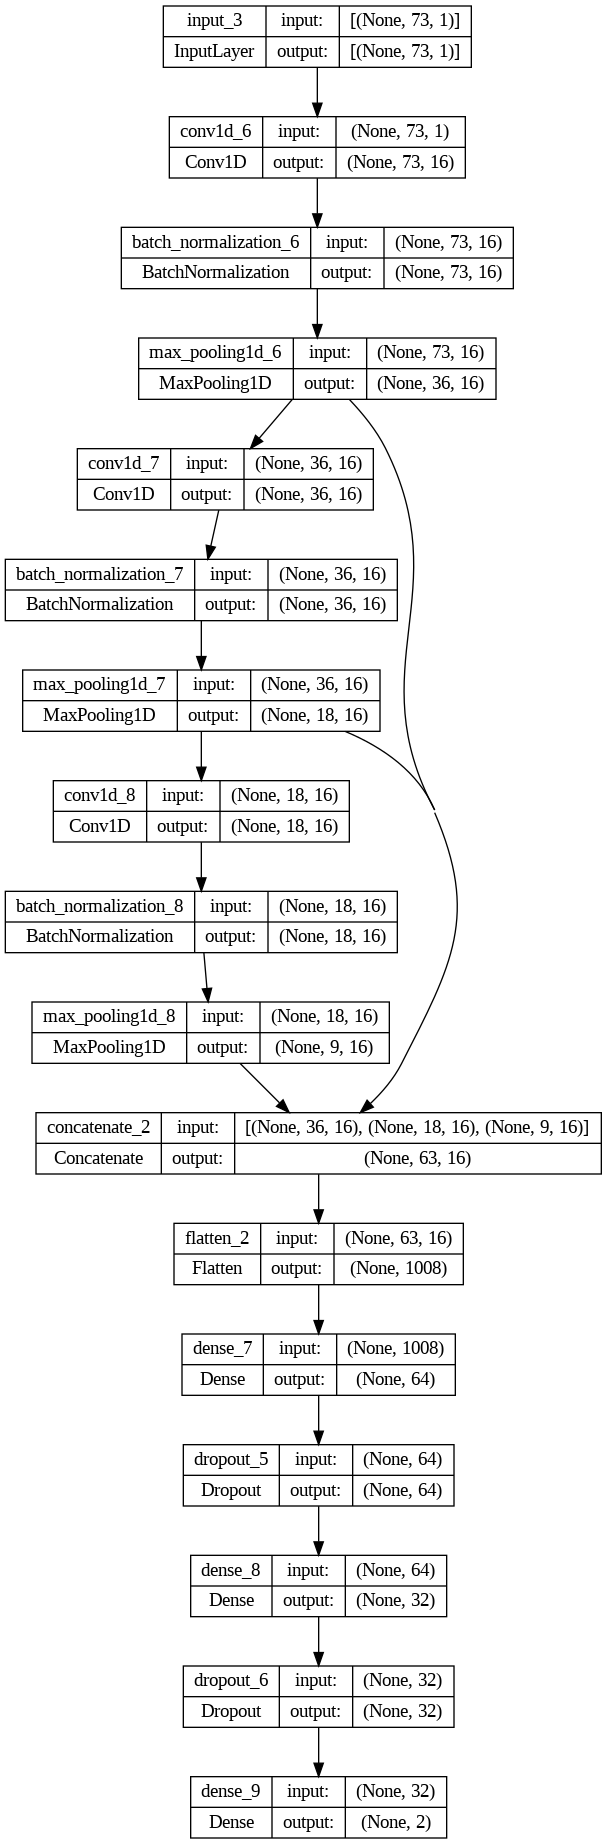

In [ ]:
from keras.utils.vis_utils import plot_model
model_loaded.summary()
plot_model(model_loaded, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Test accuracy for 3 Conv + 2 Dense used in Table 7**

In [ ]:
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 21s 3ms/step - loss: 0.0116 - accuracy: 0.9960
Test loss: 0.011592697352170944
Test accuracy: 0.9960041046142578


**Table 7: 2 Conv + 2 Dense**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/custom_3_layer_decrese/weights-improvement-30-0.9879.hdf5')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 73, 1)]      0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 73, 16)       112         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 73, 16)      64          ['conv1d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling1d_11 (MaxPooling1D  (None, 36, 16)      0           ['batch_normalization_11[0]

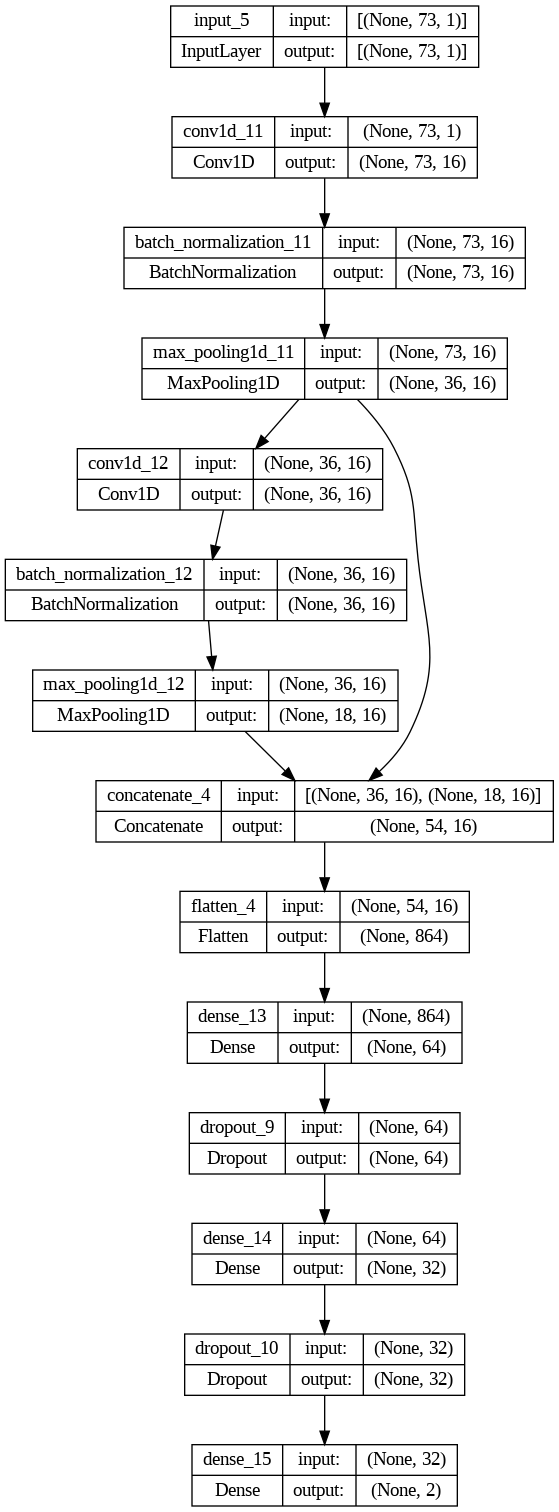

In [ ]:
from keras.utils.vis_utils import plot_model
model_loaded.summary()
plot_model(model_loaded, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Test accuracy for 2 Conv + 2 Dense used in Table 7**

In [ ]:
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 16s 3ms/step - loss: 0.0159 - accuracy: 0.9945
Test loss: 0.01591920666396618
Test accuracy: 0.9944992065429688


**Table 7: 2 Conv + 1 Dense**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c3,4,d1,2/weights-improvement-96-0.9805.hdf5')

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 73, 1)]      0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 73, 16)       112         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 73, 16)      64          ['conv1d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling1d_15 (MaxPooling1D  (None, 36, 16)      0           ['batch_normalization_15[0]

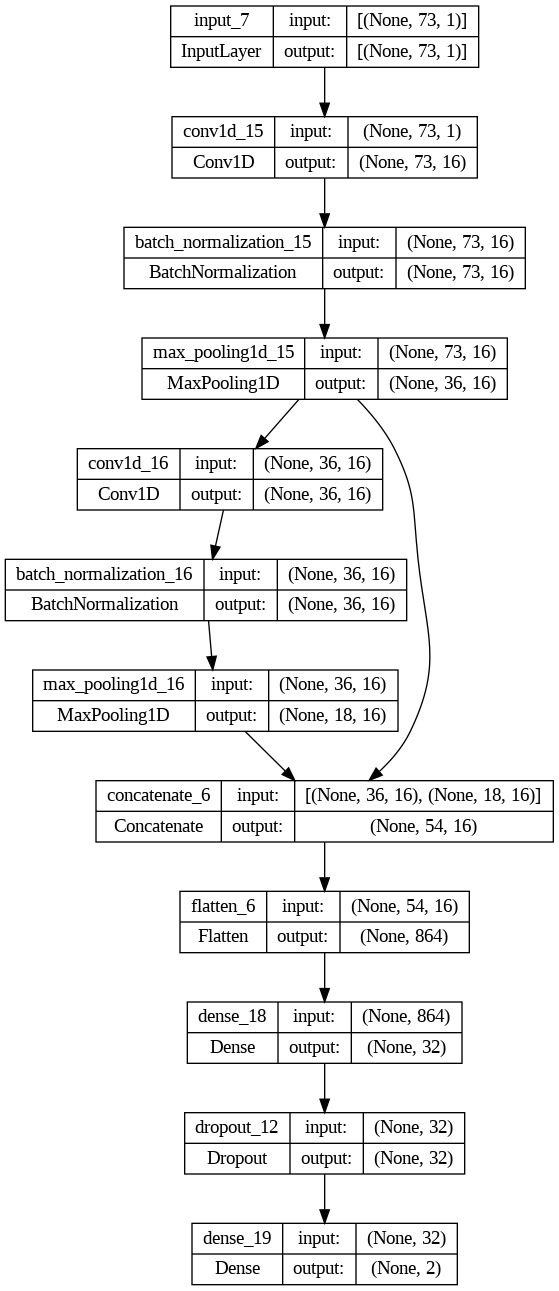

In [ ]:
from keras.utils.vis_utils import plot_model
model_loaded.summary()
plot_model(model_loaded, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Fit the model: Table 7 -> 2 Conv + 1 Dense (M2)**


In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
4678/4685 [============================>.] - ETA: 0s - loss: 0.3000 - accuracy: 0.8624
Epoch 1: accuracy improved from -inf to 0.86245, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c3,4,d1,2/weights-improvement-01-0.8625.hdf5
4685/4685 [==============================] - 22s 5ms/step - loss: 0.2999 - accuracy: 0.8625
Epoch 2/100
4679/4685 [============================>.] - ETA: 0s - loss: 0.1876 - accuracy: 0.9117
Epoch 2: accuracy improved from 0.86245 to 0.91169, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c3,4,d1,2/weights-improvement-02-0.9117.hdf5
4685/4685 [==============================] - 22s 5ms/step - loss: 0.1875 - accuracy: 0.9117
Epoch 3/100
4681/4685 [============================>.] - ETA: 0s - loss: 0.1512 - accuracy: 0.9275
Epoch 3: accuracy improved from 0.91169 to 0.92754, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c3,4,d

**Test accuracy for 2 Conv + 1 Dense used in Table 7**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 11s 2ms/step - loss: 0.0206 - accuracy: 0.9923
Test loss: 0.02064960077404976
Test accuracy: 0.9922963380813599


**Table 7 -> 1 Conv + 2 Dense**

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 73, 1)]           0         
                                                                 
 conv1d_48 (Conv1D)          (None, 73, 16)            112       
                                                                 
 batch_normalization_48 (Bat  (None, 73, 16)           64        
 chNormalization)                                                
                                                                 
 max_pooling1d_48 (MaxPoolin  (None, 36, 16)           0         
 g1D)                                                            
                                                                 
 concatenate_14 (Concatenate  (None, 36, 16)           0         
 )                                                               
                                                          

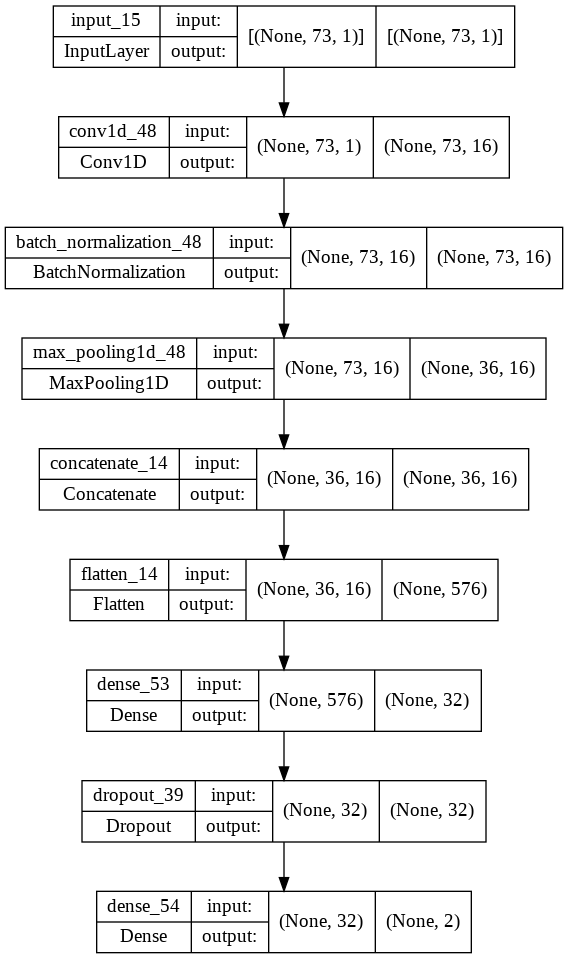

In [ ]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model


intput_shape=(x_train.shape[1], 1) #x_train.shape[1]

input_layer = Input(intput_shape)

conv1 = Conv1D(16, kernel_size=6,padding = 'same',activation='relu') (input_layer)
bn1 = BatchNormalization() (conv1)
pool1 = MaxPooling1D(pool_size=(2)) (bn1)



connect1 = concatenate([pool1], axis=1)


flat = Flatten() (connect1)

dense2 = Dense(256, activation='relu') (drop1)
drop2 = Dropout(0.2) (dense2)


dense3 = Dense(32, activation='relu') (flat)
drop3 = Dropout(0.2) (dense3)

output_layer = Dense(2, activation='softmax') (drop3) #num_classes

model = Model(input_layer, output_layer)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Fit the model: Table 7 -> 1 Conv + 2 Dense**

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
4677/4685 [============================>.] - ETA: 0s - loss: 0.3373 - accuracy: 0.8479
Epoch 1: accuracy improved from -inf to 0.84794, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c2,c3,d1/weights-improvement-01-0.8479.hdf5
4685/4685 [==============================] - 22s 5ms/step - loss: 0.3372 - accuracy: 0.8479
Epoch 2/100
4684/4685 [============================>.] - ETA: 0s - loss: 0.2429 - accuracy: 0.8913
Epoch 2: accuracy improved from 0.84794 to 0.89134, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c2,c3,d1/weights-improvement-02-0.8913.hdf5
4685/4685 [==============================] - 21s 4ms/step - loss: 0.2429 - accuracy: 0.8913
Epoch 3/100
4678/4685 [============================>.] - ETA: 0s - loss: 0.2055 - accuracy: 0.9065
Epoch 3: accuracy improved from 0.89134 to 0.90649, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/MDPI_Conv_Layer/c2,c3,d1

**Test accuracy for 1 Conv + 2 Dense used in Table 7**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 11s 2ms/step - loss: 0.0699 - accuracy: 0.9693
Test loss: 0.06985320895910263
Test accuracy: 0.9692558646202087
